# Анализ пользовательского поведения в мобильном приложении

## Описание проекта

Я работаю в стартапе, который продаёт продукты питания. Моя задача - изучить поведение пользователей мобильного приложения.

Для этого нужно провести анализ воронки продаж, чтобы узнать, какие шаги пользователи проходят перед покупкой и на каких этапах возникают проблемы.

После этого запустить A/A/B-эксперимент, где пользователей разделить на две контрольные группы и одну экспериментальную группу. Нужно определить, как изменение шрифтов в приложении повлияет на поведение пользователей.

## Описание данных

Каждая запись в логе — это действие пользователя, или событие.

`EventName` — название события;  
`DeviceIDHash` — уникальный идентификатор пользователя;  
`EventTimestamp` — время события;  
`ExpId` — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.  

## План (декомпозиция) анализа данных:   

1. Загрузка данных и изучение общей информации.
2. Подготовка данных к анализу.
3. Изучение и проверка данных.
4. Изучение воронки событий.
5. Изучение результатов эксперимента.
6. Общий вывод.

## Шаг 1. Загрузка данных и изучение общей информации. 

In [1]:
import pandas as pd
import scipy.stats as stats
from scipy import stats as st
import numpy as np
import math as mth
import matplotlib.pyplot as plt
import plotly.offline as pyo
import plotly.graph_objs as go
from plotly import graph_objects as go

pyo.init_notebook_mode(connected=True)

In [2]:
data = pd.read_csv('/datasets/logs_exp.csv', sep='\t')

In [3]:
display(data.head(10))

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
5,CartScreenAppear,6217807653094995999,1564055323,248
6,OffersScreenAppear,8351860793733343758,1564066242,246
7,MainScreenAppear,5682100281902512875,1564085677,246
8,MainScreenAppear,1850981295691852772,1564086702,247
9,MainScreenAppear,5407636962369102641,1564112112,246


Видим, что имеются время события имеет формат не даты, а названия столбцов написаны в верблюжьем регистре.

Посмотрим на уникальные названия событий:

In [4]:
data['EventName'].unique()

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

Общая информация:

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


Всего 244126 строк. Пропуски отсутствуют. Также видим, что тип данных в столбце `EventTimestamp` формата данных `int64` вместо `datetime64`.

__Промежуточный вывод:__ изучили общую информацию:  
- Увидели, что в данных нет пропусков.  
- Названия столбцов указаны в верблюжьем регистре.  
- Тип данных в столбце `EventTimestamp` `int` вместо `datetime64`.

## Шаг 2. Подготовка данных к анализу.

### Заменим названия столбцов.

Приведем название столбцов к змеиному регистру.

In [6]:
data.columns =['event_name', 'device_id_hash', 'event_timestamp', 'exp_id']

In [7]:
data.head()

,event_name,device_id_hash,event_timestamp,exp_id
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


Привели названия столбцов к змеиному регистру.

### Проверим пропуски и типы данных.

Проверим пропуски:

In [8]:
pd.DataFrame(round(data.isna().mean()*100,1)).style.background_gradient('coolwarm')

,0
event_name,0.000000
device_id_hash,0.000000
event_timestamp,0.000000
exp_id,0.000000


Изменим тип данных в столбце `event_timestamp` на `datetime64`.

In [9]:
data['event_timestamp'] = pd.to_datetime(data['event_timestamp'], unit='s')

In [10]:
data.head()

,event_name,device_id_hash,event_timestamp,exp_id
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248


Изменили тип данных в столбце `event_timestamp` на `datetime64`, пропуски отсутствуют.

### Проверим на наличие дубликатов.

In [11]:
print(f"Количество дубликатов - {data.duplicated().sum()}, доля дубликатов - {round(data.duplicated().sum()/data['event_name'].count()*100, 2)}%")

Количество дубликатов - 413, доля дубликатов - 0.17%


Найдено 411 дубликатов (0,17%), удалим их и пронумеруем заново индексы.

In [12]:
data = data.drop_duplicates().reset_index(drop=True)

### Проверим, не пересекаются ли пользователи между группами.

In [13]:
group_ids = [246, 247, 248]

for i in range(len(group_ids)):
    for j in range(i+1, len(group_ids)):
        group_i = data.query(f'exp_id == {group_ids[i]}')
        group_j = data.query(f'exp_id == {group_ids[j]}')
        common_users = group_i.merge(group_j, how='inner', on='device_id_hash')
        count = common_users['device_id_hash'].count()
        share = round(common_users['device_id_hash'].nunique() / data['device_id_hash'].nunique() * 100, 1)
        print(f"Количество пользователей, которые входят одновременно в группы {group_ids[i]} и {group_ids[j]}: {count}, \
что составляет {share}% от всех пользователей.")

Количество пользователей, которые входят одновременно в группы 246 и 247: 0, что составляет 0.0% от всех пользователей.
Количество пользователей, которые входят одновременно в группы 246 и 248: 0, что составляет 0.0% от всех пользователей.
Количество пользователей, которые входят одновременно в группы 247 и 248: 0, что составляет 0.0% от всех пользователей.


Пользователи не пересекаются между группами.

### Добавим столбец даты и времени, а также отдельный столбец дат.

In [14]:
data['event_ts'] = data['event_timestamp']
data['event_date'] = data['event_timestamp'].dt.date
data.head()

,event_name,device_id_hash,event_timestamp,exp_id,event_ts,event_date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25 11:48:42,2019-07-25


Добавили столбец даты и времени, а также отдельный столбец дат.

__Промежуточный вывод:__ провели подготовку данных к анализу:  
- Привели названия столбцов к змеиному регистру.  
- Изменили тип данных в столбце `event_timestamp` на `datetime64`, пропуски в данных отсутствуют.  
- Нашли 411 дубликатов (0,17%), удалили их и заново пронумеровали индексы.  
- Проверили, что пользователи не пересекаются между группами.
- Добавили столбец даты и времени, а также отдельный столбец дат.

## Шаг 3. Изучение и проверка данных.

### Посчитаем сколько всего событий в логе.

In [15]:
data['event_name'].count()

243713

Всего 243713 событий в логе.

### Посчитаем сколько всего пользователей в логе.

In [16]:
data['device_id_hash'].nunique()

7551

Всего 7551 пользователь в логе.

### Посчитаем сколько в среднем событий приходится на пользователя.

In [17]:
round(data['event_name'].count()/data['device_id_hash'].nunique())

32

В среднем приходится 32 события на пользователя.

### Проверим существование аномальных пользователей, которые совершали очень много событий.

count    2.437130e+05
mean     4.627963e+18
std      2.642723e+18
min      6.888747e+15
25%      2.372212e+18
50%      4.623192e+18
75%      6.932517e+18
max      9.222603e+18
Name: device_id_hash, dtype: float64

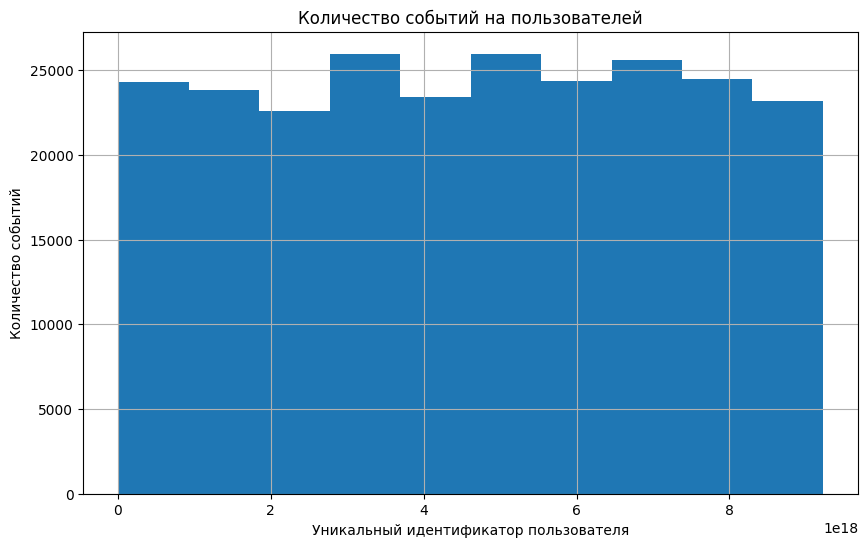

In [18]:
display(data['device_id_hash'].describe())

data['device_id_hash'].hist(figsize=(10, 6))
plt.xlabel('Уникальный идентификатор пользователя')
plt.ylabel('Количество событий')
plt.title('Количество событий на пользователей');

Аномальных пользователей, совершивших очень много событий, не обнаружено.

### Найдем максимальную и минимальную дату событий.

In [19]:
display(data['event_date'].min())
data['event_date'].max()

datetime.date(2019, 7, 25)

datetime.date(2019, 8, 7)

Мы располгагаем данными с 25.07.2019 по 07.08.2019.

### Построим гистограмму по дате и времени. Проверим, что у нас одинаково полные данные за весь период.

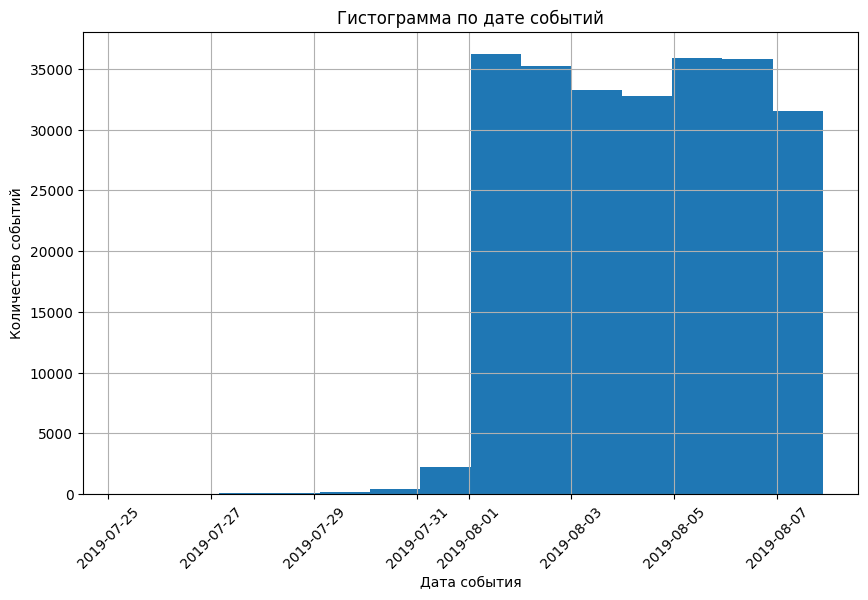

In [20]:
data['event_ts'].hist(figsize=(10, 6), bins=14)
plt.xlabel('Дата события')
plt.ylabel('Количество событий')
plt.title('Гистограмма по дате событий')
plt.xticks(rotation=45);

По графику видим, что у нас одинаково полные данные с 01.08.2019 по 07.08.2019. Будем использовать их.

### Посчитаем сколько событий и пользователей мы потеряли, отбросив старые данные.

In [21]:
old_data = data.query('event_ts < "2019-08-01"')
new_data = data.query('event_ts >= "2019-08-01"')

print(f"Отбросив старые данные, мы потеряли {old_data['event_name'].count()} событий \
({round(old_data['event_name'].count()/data['event_name'].count()*100, 2)}%) и \
{data['device_id_hash'].nunique()-new_data['device_id_hash'].nunique()} пользователей \
({round((data['device_id_hash'].nunique()-new_data['device_id_hash'].nunique())/data['device_id_hash'].nunique()*100, 2)}%).")

Отбросив старые данные, мы потеряли 2826 событий (1.16%) и 17 пользователей (0.23%).


Отбросив старые данные, мы потеряли 2826 событий (1.16%) и 17 пользователей (0.23%).

### Проверим, что у нас есть пользователи из всех трёх экспериментальных групп.

In [23]:
new_data['exp_id'].value_counts()

exp_id
248    84563
246    79302
247    77022
Name: count, dtype: int64

Проверили, что в новых данных для анализа имеются пользователи из всех трёх экспериментальных групп.

__Промежуточный вывод:__ изучили и проверили данные:
- Всего 243713 событий в логе.
- Всего 7551 пользователь в логе.
- В среднем приходится 32 события на пользователя.
- Аномальных пользователей, совершивших очень много событий, не обнаружено.
- Мы располгагаем данными с 25.07.2019 по 07.08.2019.
- По гистограмме по дате и времени видим, что у нас одинаково полные данные с 01.08.2019 по 07.08.2019.
- Отбросив данные до 01.08.2019, мы потеряли 2826 событий (1.16%) и 17 пользователей (0.23%).
- Проверили, что в новых данных для анализа имеются пользователи из всех трёх экспериментальных групп.

## Шаг 4. Изучение воронки событий.

### Посмотрим, какие события есть в логах, как часто они встречаются. Отсортируем события по частоте.

In [24]:
new_data['event_name'].value_counts()

event_name
MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: count, dtype: int64

Самым частым событием является показ главного экрана `MainScreenAppear` - 117328 раз, далее экран предложения `OffersScreenAppear` - 46333 раза, экран корзины `CartScreenAppear` - 42303 раза, экран успешной оплаты `PaymentScreenSuccessful` - 33918 раз. Наименее частым событием является руководство `Tutorial` - всего 1005 раз.

### Посчитаем, сколько пользователей совершали каждое из этих событий. Отсортируем события по числу пользователей. Посчитаем долю пользователей, которые хоть раз совершали событие.

In [25]:
users = (
    new_data
    .groupby('event_name')
    .agg({'device_id_hash': 'nunique'})
    .sort_values(by='device_id_hash', ascending=False)
    .rename(columns={'device_id_hash': 'users_count'})
    .reset_index()
)
users['users_share'] = round(users['users_count'] / data['device_id_hash'].nunique(), 2)
users

,event_name,users_count,users_share
0,MainScreenAppear,7419,0.98
1,OffersScreenAppear,4593,0.61
2,CartScreenAppear,3734,0.49
3,PaymentScreenSuccessful,3539,0.47
4,Tutorial,840,0.11


98% пользователей увидели главный экран приложения, 61% - экран предложения, 49% - экран корзины, 47% - экран успешной оплаты и 11% - руководство.

### Предположим, в каком порядке происходят события.

Предположим следующий порядок событий в приложении:

1. Пользователь впервые открыл приложение и получил уведомление о знакомстве с руководством. Он может закрыть уведомление или прочитать руководство (событие `Tutorial`) и перейти на главный экран. Событие `Tutorial` является необязательным для работы с приложением.
2. Пользователь увидел главный экран (событие `MainScreenAppear`), где он может выбрать нужный раздел с продуктами питания.
3. Пользователь выбрал раздел с продуктами питания.
4. Пользователь увидел экран предложения (событие `OffersScreenAppear`), где он может выбрать необходимое количество товаров.
5. Пользователь нажал на кнопку "Перейти в корзину".
6. Пользователь увидел экран корзины (событие `CartScreenAppear`), где он может выбрать адрес доставки и ввести способ оплаты.
7. Пользователь ввел платежные реквизиты и нажал кнопку "Оплатить".
8. Пользователь увидел экран успешной оплаты (событие `PaymentScreenSuccessful`).

### По воронке событий посчитаем, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем).

Рассчитаем доли пользователей, перешедших на следующий шаг воронки, исключив необязательное событие `Tutorial`.

In [26]:
users['conversion_rate'] = round(users['users_count'] / users['users_count'].shift(1), 2)
users['conversion_rate'].fillna(1, inplace=True)  # Заменим NaN на 1
users = users.drop(4)
users

,event_name,users_count,users_share,conversion_rate
0,MainScreenAppear,7419,0.98,1.00
1,OffersScreenAppear,4593,0.61,0.62
2,CartScreenAppear,3734,0.49,0.81
3,PaymentScreenSuccessful,3539,0.47,0.95


62% пользователей, открывших главный экран, перешли на экран предложения, 81% пользователей перешли к экрану корзины, 95% пользователей оплатили товары в корзине.

### На каком шаге теряем больше всего пользователей?

Больше всего пользователей теряем на переходе к экрану предложения (событие `OffersScreenAppear`) - 2826 пользователей (37%).

### Какая доля пользователей доходит от первого события до оплаты?

In [27]:
round(users.loc[3, 'users_count']/users.loc[0, 'users_count'], 2)

0.48

48% пользователей доходят от первого события до оплаты.

### Построим график воронки событий по пользователям (по количеству).

In [28]:
fig = go.Figure(go.Funnel(
    y = users['event_name'],
    x = users['users_count'])
    )
fig.update_layout(title="Воронка событий")
fig.show()

__Промежуточный вывод:__ изучили воронку событий:
- Самым частым событием является показ главного экрана `MainScreenAppear` - 117328 раз, далее экран предложения `OffersScreenAppear` - 46333 раза, экран корзины `CartScreenAppear` - 42303 раза, экран успешной оплаты `PaymentScreenSuccessful` - 33918 раз. Наименее частым событием является руководство `Tutorial` - всего 1005 раз.
- 98% пользователей увидели главный экран приложения, 61% - экран предложения, 49% - экран корзины, 47% - экран успешной оплаты и 11% - руководство.
- Предположили следующий порядок событий в приложении:
    1. Пользователь впервые открыл приложение и получил уведомление о знакомстве с руководством. Он может закрыть уведомление или прочитать руководство (событие `Tutorial`) и перейти на главный экран. Событие `Tutorial` является необязательным для работы с приложением.
    2. Пользователь увидел главный экран (событие `MainScreenAppear`), где он может выбрать нужный раздел с продуктами питания.
    3. Пользователь выбрал раздел с продуктами питания.
    4. Пользователь увидел экран предложения (событие `OffersScreenAppear`), где он может выбрать необходимое количество товаров.
    5. Пользователь нажал на кнопку "Перейти в корзину".
    6. Пользователь увидел экран корзины (событие `CartScreenAppear`), где он может выбрать адрес доставки и ввести способ оплаты.
    7. Пользователь ввел платежные реквизиты и нажал кнопку "Оплатить".
    8. Пользователь увидел экран успешной оплаты (событие `PaymentScreenSuccessful`).
- 62% пользователей, открывших главный экран, перешли на экран предложения, 81% пользователей перешли к экрану корзины, 95% пользователей оплатили товары в корзине.
- Больше всего пользователей теряем на переходе к экрану предложения (событие `OffersScreenAppear`) - 2826 пользователей (37%).
- 48% пользователей доходят от первого события до оплаты.

## Шаг 5. Изучение результатов эксперимента.

In [29]:
# Напишем функцию для расчета доли пользователей, перешедших на следующий шаг воронки, для каждой из групп
def conversion_rate(group):
    users = (
        data
        .query('exp_id == @group')
        .groupby('event_name')
        .agg({'device_id_hash': 'nunique'})
        .sort_values(by='device_id_hash', ascending=False)
        .rename(columns={'device_id_hash': 'users_count'})
        .reset_index()
        .drop(4)
    )
    users['users_share'] = round(users['users_count'] / data['device_id_hash'].nunique(), 2)
    users['conversion_rate'] = round(users['users_count'] / users['users_count'].shift(1), 2)
    users['conversion_rate'].fillna(1, inplace=True)  # Заменим NaN на 1
    return users

Посчитаем, какая доля пользователей проходит на следующий шаг воронки для каждой из групп.

In [30]:
conversion_rate(246)

,event_name,users_count,users_share,conversion_rate
0,MainScreenAppear,2456,0.33,1.00
1,OffersScreenAppear,1545,0.20,0.63
2,CartScreenAppear,1270,0.17,0.82
3,PaymentScreenSuccessful,1202,0.16,0.95


In [31]:
conversion_rate(247)

,event_name,users_count,users_share,conversion_rate
0,MainScreenAppear,2482,0.33,1.00
1,OffersScreenAppear,1530,0.20,0.62
2,CartScreenAppear,1240,0.16,0.81
3,PaymentScreenSuccessful,1160,0.15,0.94


In [32]:
conversion_rate(248)

,event_name,users_count,users_share,conversion_rate
0,MainScreenAppear,2501,0.33,1.00
1,OffersScreenAppear,1538,0.20,0.61
2,CartScreenAppear,1239,0.16,0.81
3,PaymentScreenSuccessful,1185,0.16,0.96


По результатам эксперимента видим, что доля пользователей, оплативших товары в корзине, в экспериментальной группе 248 не отличается от контрольной группы 246. Доля пользователей, которая проходит на следующий шаг воронки, в экспериментальной группе 248 отличается от контрольных групп на 1-2%. Можно сделать вывод, что новые шрифты в приложении для пользователей не показались непривычными, но в то же время показатели продаж не изменились. Поэтому сказать, что новый шрифт лучше старого мы не можем. Тем не менее, изменение шрифта во всем приложении не вызовет отторжения у пользователей.

### Сколько пользователей в каждой экспериментальной группе?

In [33]:
for group_id in group_ids:
    count = data.query(f'exp_id == {group_id}')['device_id_hash'].nunique()
    if count % 10 == 1 and count % 100 != 11:
        print(f"В группе {group_id} - {count} {'пользователь.'}")
    if 2 <= count % 10 <= 3 and not (10 < count % 100 < 20):
        print(f"В группе {group_id} - {count} {'пользователя.'}")
    else:
        print(f"В группе {group_id} - {count} {'пользователей.'}")

В группе 246 - 2489 пользователей.
В группе 247 - 2520 пользователей.
В группе 248 - 2542 пользователя.


В группе 246 - 2489 пользователей, 247 - 2520 пользователей, 248 - 2542 пользователя.

### Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверим, находят ли статистические критерии разницу между выборками 246 и 247.

Для проверки наличия статистически значимой разницы между контрольными выборками 246 и 247 используем непараметрический критерий Манна-Уитни.

Сформулируем нулевую и альтернативную гипотезы.
- Нулевая гипотеза (H0): между выборками 246 и 247 нет статистически значимых различий.
- Альтернативная гипотеза (H1): между выборками 246 и 247 статистически значимые различия есть.

Зададим уровень статистической значимости: 0,05.

In [34]:
print('P-value: {0:.3f}'.format(stats.mannwhitneyu(data.query('exp_id == 246')['device_id_hash'].unique(), data.query('exp_id == 247')['device_id_hash'].unique())[1]))

P-value: 0.707


По критерию Манна-Уитни p-value больше 0,05 - статистически значимых различий в контрольных группах 246 и 247 нет.

### Выберем самое популярное событие. Посчитаем число пользователей, совершивших это событие в каждой из контрольных групп. Посчитаем долю пользователей, совершивших это событие. Проверим, будет ли отличие между группами статистически достоверным. Проделаем то же самое для всех других событий.

Самым популярным событием является `MainScreenAppear`.

In [35]:
print(f'Количество пользователей в группе 246:', data.query('exp_id == 246 and event_name == "MainScreenAppear"')['device_id_hash'].nunique())
print(f'Количество пользователей в группе 247:', data.query('exp_id == 247 and event_name == "MainScreenAppear"')['device_id_hash'].nunique())

Количество пользователей в группе 246: 2456
Количество пользователей в группе 247: 2482


In [36]:
print(f'Доля пользователей в группе 246:', round(data.query('exp_id == 246 and event_name == "MainScreenAppear"')['device_id_hash'].nunique()/data.query('exp_id == 246')['device_id_hash'].nunique(), 2))
print(f'Доля пользователей в группе 247:', round(data.query('exp_id == 247 and event_name == "MainScreenAppear"')['device_id_hash'].nunique()/data.query('exp_id == 247')['device_id_hash'].nunique(), 2))

Доля пользователей в группе 246: 0.99
Доля пользователей в группе 247: 0.98


Количество пользователей, совершивших событие `MainScreenAppear`:
- в контрольной группе 246 - 2456 пользователей (99%), 
- в контрольной группе 247 - 2482 пользователей (98%).

Проверим, будет ли отличие между группами статистически достоверным.

Сформулируем нулевую и альтернативную гипотезы.
- Нулевая гипотеза (H0): между контрольными группами 246 и 247, в которых пользователи совершили заданное событие, нет статистически значимых различий.
- Альтернативная гипотеза (H1): между контрольными группами 246 и 247, в которых пользователи совершили заданное событие, статистически значимые различия есть.

Зададим уровень статистической значимости: 0,05. Обернем проверку в отдельную функцию `get_p_value()` с параметрами: событие `event`, группы `group_a`, `group_b`, уровень статистической значимости `alpha`.

In [37]:
def get_p_value(event, group_a, group_b, alpha):
    event_users = np.array([data.query('exp_id == @group_a and event_name == @event')['device_id_hash'].nunique(), data.query('exp_id == @group_b and event_name == @event')['device_id_hash'].nunique()]) # количество пользователей, совершивших событие
    all_users = np.array([data.query('exp_id == @group_a')['device_id_hash'].nunique(), data.query('exp_id == @group_b')['device_id_hash'].nunique()]) # общее количество пользователей

    # пропорция пользователей, совершивших событие, в первой группе:
    p1 = event_users[0]/all_users[0]

    # пропорция пользователей, совершивших событие, во второй группе:
    p2 = event_users[1]/all_users[1]

    # пропорция пользователей, совершивших событие, в комбинированном датасете:
    p_combined = (event_users[0] + event_users[1]) / (all_users[0] + all_users[1])

    # разница пропорций в датасетах
    difference = p1 - p2

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/all_users[0] + 1/all_users[1]))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1) 

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('P-значение: ', round(p_value, 3))

    if p_value < alpha:
        print(f'Отвергаем нулевую гипотезу: между группами {group_a} и {group_b}, в которых пользователи совершили событие {event}, есть статистически значимое различие.')
    else:
        print(f'Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы {group_a} и {group_b}, в которых пользователи совершили событие {event}, разными.')

Передадим функции `get_p_value()` параметры: событие `MainScreenAppear`, контрольные группы 246, 247, уровень статистической значимости 0.05.

In [38]:
get_p_value("MainScreenAppear", 246, 247, 0.05)

P-значение:  0.586
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы 246 и 247, в которых пользователи совершили событие MainScreenAppear, разными.


Передадим функции `get_p_value()` параметры: событие `OffersScreenAppear`, контрольные группы 246, 247, уровень статистической значимости 0.05.

In [39]:
get_p_value("OffersScreenAppear", 246, 247, 0.05)

P-значение:  0.323
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы 246 и 247, в которых пользователи совершили событие OffersScreenAppear, разными.


Передадим функции `get_p_value()` параметры: событие `CartScreenAppear`, контрольные группы 246, 247, уровень статистической значимости 0.05.

In [40]:
get_p_value("CartScreenAppear", 246, 247, 0.05)

P-значение:  0.198
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы 246 и 247, в которых пользователи совершили событие CartScreenAppear, разными.


Передадим функции `get_p_value()` параметры: событие `PaymentScreenSuccessful`, контрольные группы 246, 247, уровень статистической значимости 0.05.

In [41]:
get_p_value("PaymentScreenSuccessful", 246, 247, 0.05)

P-значение:  0.109
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы 246 и 247, в которых пользователи совершили событие PaymentScreenSuccessful, разными.


Можно сделать вывод, что разбиение на группы работает корректно. А/А-эксперимент проведен успешно и мы можем быть уверены в точности проведенного тестирования.

### Аналогично поступим с группой с изменённым шрифтом.

Сформулируем нулевую и альтернативную гипотезы.
- Нулевая гипотеза (H0): между экспериментальной группой и контрольной группой, в которых пользователи совершили заданное событие, нет статистически значимых различий.
- Альтернативная гипотеза (H1): между экспериментальной группой и контрольной группой, в которых пользователи совершили заданное событие, статистически значимые различия есть.

Зададим уровень статистической значимости: 0,05. Обернем проверку в отдельную функцию `get_p_value()` с параметрами: событие `event`, группы `group_a`, `group_b`.

Передадим функции `get_p_value()` параметры: событие `MainScreenAppear`, группы 246, 248, уровень статистической значимости 0.05.

In [42]:
get_p_value("MainScreenAppear", 246, 248, 0.05)

P-значение:  0.398
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы 246 и 248, в которых пользователи совершили событие MainScreenAppear, разными.


Передадим функции `get_p_value()` параметры: событие `OffersScreenAppear`, группы 246, 248, уровень статистической значимости 0.05.

In [43]:
get_p_value("OffersScreenAppear", 246, 248, 0.05)

P-значение:  0.253
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы 246 и 248, в которых пользователи совершили событие OffersScreenAppear, разными.


Передадим функции `get_p_value()` параметры: событие `CartScreenAppear`, группы 246, 248, уровень статистической значимости 0.05.

In [44]:
get_p_value("CartScreenAppear", 246, 248, 0.05)

P-значение:  0.105
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы 246 и 248, в которых пользователи совершили событие CartScreenAppear, разными.


Передадим функции `get_p_value()` параметры: событие `PaymentScreenSuccessful`, группы 246, 248, уровень статистической значимости 0.05.

In [45]:
get_p_value("PaymentScreenSuccessful", 246, 248, 0.05)

P-значение:  0.234
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы 246 и 248, в которых пользователи совершили событие PaymentScreenSuccessful, разными.


Передадим функции `get_p_value()` параметры: событие `MainScreenAppear`, группы 247, 248, уровень статистической значимости 0.05.

In [46]:
get_p_value("MainScreenAppear", 247, 248, 0.05)

P-значение:  0.763
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы 247 и 248, в которых пользователи совершили событие MainScreenAppear, разными.


Передадим функции `get_p_value()` параметры: событие `OffersScreenAppear`, группы 247, 248, уровень статистической значимости 0.05.

In [47]:
get_p_value("OffersScreenAppear", 247, 248, 0.05)

P-значение:  0.878
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы 247 и 248, в которых пользователи совершили событие OffersScreenAppear, разными.


Передадим функции `get_p_value()` параметры: событие `CartScreenAppear`, группы 247, 248, уровень статистической значимости 0.05.

In [48]:
get_p_value("CartScreenAppear", 247, 248, 0.05)

P-значение:  0.741
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы 247 и 248, в которых пользователи совершили событие CartScreenAppear, разными.


Передадим функции `get_p_value()` параметры: событие `PaymentScreenSuccessful`, группы 247, 248, уровень статистической значимости 0.05.

In [49]:
get_p_value("PaymentScreenSuccessful", 247, 248, 0.05)

P-значение:  0.676
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы 247 и 248, в которых пользователи совершили событие PaymentScreenSuccessful, разными.


Сравним результаты с объединённой контрольной группой. Обернем проверку в отдельную функцию get_p_value_united() с параметрами: событие `event`, уровень статистической значимости `alpha`.

In [50]:
def get_p_value_united(event, alpha):
    event_users = np.array([data.query('exp_id == 248 and event_name == @event')['device_id_hash'].nunique(), data.query('(exp_id == 246 or exp_id == 247) and event_name == @event')['device_id_hash'].nunique()]) # количество пользователей, совершивших событие
    all_users = np.array([data.query('exp_id == 248')['device_id_hash'].nunique(), data.query('exp_id == 246 or exp_id == 247')['device_id_hash'].nunique()]) # общее количество пользователей

    # пропорция пользователей, совершивших событие, в первой группе:
    p1 = event_users[0]/all_users[0]

    # пропорция пользователей, совершивших событие, во второй группе:
    p2 = event_users[1]/all_users[1]

    # пропорция пользователей, совершивших событие, в комбинированном датасете:
    p_combined = (event_users[0] + event_users[1]) / (all_users[0] + all_users[1])

    # разница пропорций в датасетах
    difference = p1 - p2

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/all_users[0] + 1/all_users[1]))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1) 

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('P-значение: ', round(p_value, 3))

    if p_value < alpha:
        print(f'Отвергаем нулевую гипотезу: между экспериментальной группой и объединенной контрольной группой, в которых пользователи совершили событие {event}, есть статистически значимое различие.')
    else:
        print(f'Не получилось отвергнуть нулевую гипотезу, нет оснований считать экспериментальную группу и объединенную контрольную группу, в которых пользователи совершили событие {event}, разными.')

Передадим функции `get_p_value_united()` параметры: событие `MainScreenAppear`, уровень статистической значимости 0.05.

In [51]:
get_p_value_united("MainScreenAppear", 0.05)

P-значение:  0.507
Не получилось отвергнуть нулевую гипотезу, нет оснований считать экспериментальную группу и объединенную контрольную группу, в которых пользователи совершили событие MainScreenAppear, разными.


Передадим функции `get_p_value_united()` параметры: событие `OffersScreenAppear`, уровень статистической значимости 0.05.

In [52]:
get_p_value_united("OffersScreenAppear", 0.05)

P-значение:  0.456
Не получилось отвергнуть нулевую гипотезу, нет оснований считать экспериментальную группу и объединенную контрольную группу, в которых пользователи совершили событие OffersScreenAppear, разными.


Передадим функции `get_p_value_united()` параметры: событие `CartScreenAppear`, уровень статистической значимости 0.05.

In [53]:
get_p_value_united("CartScreenAppear", 0.05)

P-значение:  0.261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать экспериментальную группу и объединенную контрольную группу, в которых пользователи совершили событие CartScreenAppear, разными.


Передадим функции `get_p_value_united()` параметры: событие `PaymentScreenSuccessful`, уровень статистической значимости 0.05.

In [54]:
get_p_value_united("PaymentScreenSuccessful", 0.05)

P-значение:  0.658
Не получилось отвергнуть нулевую гипотезу, нет оснований считать экспериментальную группу и объединенную контрольную группу, в которых пользователи совершили событие PaymentScreenSuccessful, разными.


По результатам проверки гипотез о равенстве долей не получилось отвергнуть нулевые гипотезы:
- Нет оснований считать экспериментальную группу и контрольную группу, в которых пользователи совершили заданные события, разными.
- Нет оснований считать экспериментальную группу и объединенную контрольную группу, в которых пользователи совершили заданные события, разными.

Можно сделать вывод, что А/В-эксперимент проведен успешно и разбиение на группы работает корректно.

### Посчитаем вероятность получения ложноположительного результата. Скорректируем уровень значимости и повторно проведем эксперименты.

При проверке статистических гипотез мы выбрали уровень значимости 0,05. Всего провели проверку 16 статистических гипотез. При каждой проверке гипотезы с уровнем значимости 0.05, существует 5% вероятность получить ложноположительный результат.

Рассчитаем вероятность получить хотя бы один ложноположительный результат при проверке 16 статистических гипотез с уровнем значимости 0.05:

1 - (1 - 0.05)^16 ≈ 0.6728

Таким образом, вероятность получить ложноположительный результат составляет 67%.

Применим метод Бонферрони для корректировки уровня значимости:

a_corr = a / m = 0.05 / 16 ≈ 0.003125

Повторно проведем эксперименты со скорректированным уровнем значимости 0.003125.

In [55]:
get_p_value("MainScreenAppear", 246, 247, 0.003125)

P-значение:  0.586
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы 246 и 247, в которых пользователи совершили событие MainScreenAppear, разными.


In [56]:
get_p_value("OffersScreenAppear", 246, 247, 0.003125)

P-значение:  0.323
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы 246 и 247, в которых пользователи совершили событие OffersScreenAppear, разными.


In [57]:
get_p_value("CartScreenAppear", 246, 247, 0.003125)

P-значение:  0.198
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы 246 и 247, в которых пользователи совершили событие CartScreenAppear, разными.


In [58]:
get_p_value("PaymentScreenSuccessful", 246, 247, 0.003125)

P-значение:  0.109
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы 246 и 247, в которых пользователи совершили событие PaymentScreenSuccessful, разными.


In [59]:
get_p_value("MainScreenAppear", 246, 248, 0.003125)

P-значение:  0.398
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы 246 и 248, в которых пользователи совершили событие MainScreenAppear, разными.


In [60]:
get_p_value("OffersScreenAppear", 246, 248, 0.003125)

P-значение:  0.253
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы 246 и 248, в которых пользователи совершили событие OffersScreenAppear, разными.


In [61]:
get_p_value("CartScreenAppear", 246, 248, 0.003125)

P-значение:  0.105
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы 246 и 248, в которых пользователи совершили событие CartScreenAppear, разными.


In [62]:
get_p_value("PaymentScreenSuccessful", 246, 248, 0.003125)

P-значение:  0.234
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы 246 и 248, в которых пользователи совершили событие PaymentScreenSuccessful, разными.


In [63]:
get_p_value("MainScreenAppear", 247, 248, 0.003125)

P-значение:  0.763
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы 247 и 248, в которых пользователи совершили событие MainScreenAppear, разными.


In [64]:
get_p_value("OffersScreenAppear", 247, 248, 0.003125)

P-значение:  0.878
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы 247 и 248, в которых пользователи совершили событие OffersScreenAppear, разными.


In [65]:
get_p_value("CartScreenAppear", 247, 248, 0.003125)

P-значение:  0.741
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы 247 и 248, в которых пользователи совершили событие CartScreenAppear, разными.


In [66]:
get_p_value("PaymentScreenSuccessful", 247, 248, 0.003125)

P-значение:  0.676
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы 247 и 248, в которых пользователи совершили событие PaymentScreenSuccessful, разными.


In [67]:
get_p_value_united("MainScreenAppear", 0.003125)

P-значение:  0.507
Не получилось отвергнуть нулевую гипотезу, нет оснований считать экспериментальную группу и объединенную контрольную группу, в которых пользователи совершили событие MainScreenAppear, разными.


In [68]:
get_p_value_united("OffersScreenAppear", 0.003125)

P-значение:  0.456
Не получилось отвергнуть нулевую гипотезу, нет оснований считать экспериментальную группу и объединенную контрольную группу, в которых пользователи совершили событие OffersScreenAppear, разными.


In [69]:
get_p_value_united("CartScreenAppear", 0.003125)

P-значение:  0.261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать экспериментальную группу и объединенную контрольную группу, в которых пользователи совершили событие CartScreenAppear, разными.


In [70]:
get_p_value_united("PaymentScreenSuccessful", 0.003125)

P-значение:  0.658
Не получилось отвергнуть нулевую гипотезу, нет оснований считать экспериментальную группу и объединенную контрольную группу, в которых пользователи совершили событие PaymentScreenSuccessful, разными.


Результаты проверки статистических гипотез со скорректированным уровнем значимости 0.003125 не изменились. При проведении экспериментов ложноположительный результат не получен.

__Промежуточный вывод:__ изучили результаты эксперимента:
- По результатам эксперимента видим, что доля пользователей, оплативших товары в корзине, в экспериментальной группе 248 не отличается от контрольной группы 246. Доля пользователей, которая проходит на следующий шаг воронки, в экспериментальной группе 248 отличается от контрольных групп на 1-2%. Можно сделать вывод, что новые шрифты в приложении для пользователей не показались непривычными, но в то же время показатели продаж не изменились. Поэтому сказать, что новый шрифт лучше старого мы не можем. Тем не менее, изменение шрифта во всем приложении не вызовет отторжения у пользователей.
- В группе 246 - 2489 пользователей, 247 - 2520 пользователей, 248 - 2542 пользователя.
- По критерию Манна-Уитни p-value больше 0,05 - статистически значимых различий в контрольных группах 246 и 247 нет.
- Самым популярным событием является `MainScreenAppear`.
- Количество пользователей, совершивших событие `MainScreenAppear`:
    - в контрольной группе 246 - 2456 пользователей (99%), 
    - в контрольной группе 247 - 2482 пользователей (98%).
- По результатам проверки гипотез о равенстве долей не получилось отвергнуть нулевые гипотезы:
    - Нет оснований считать экспериментальную группу и контрольную группу, в которых пользователи совершили заданные события, разными.
    - Нет оснований считать экспериментальную группу и объединенную контрольную группу, в которых пользователи совершили заданные события, разными.  
- Можно сделать вывод, что А/А/В-эксперимент проведен успешно и разбиение на группы работает корректно.
- При проверке 16 статистических гипотез с уровнем значимости 0.05 вероятность получить ложноположительный результат составляет 67%. 
- Результаты проверки статистических гипотез со скорректированным уровнем значимости 0.003125 не изменились. При проведении экспериментов ложноположительный результат не получен.

## Шаг 6. Общий вывод.

Провели анализ, как ведут себя пользователи мобильного приложения.

Изучили общую информацию:  
- Увидели, что в данных нет пропусков.  
- Названия столбцов указаны в верблюжьем регистре.  
- Тип данных в столбце `EventTimestamp` `int` вместо `datetime64`.

Провели подготовку данных к анализу:  
- Привели названия столбцов к змеиному регистру.  
- Изменили тип данных в столбце `event_timestamp` на `datetime64`, пропуски в данных отсутствуют.  
- Нашли 411 дубликатов (0,17%), удалили их и заново пронумеровали индексы.  
- Проверили, что пользователи не пересекаются между группами.
- Добавили столбец даты и времени, а также отдельный столбец дат.

Изучили и проверили данные:
- Всего 243713 событий в логе.
- Всего 7551 пользователь в логе.
- В среднем приходится 32 события на пользователя.
- Аномальных пользователей, совершивших очень много событий, не обнаружено.
- Мы располгагаем данными с 25.07.2019 по 07.08.2019.
- По гистограмме по дате и времени видим, что у нас одинаково полные данные с 01.08.2019 по 07.08.2019.
- Отбросив данные до 01.08.2019, мы потеряли 2826 событий (1.16%) и 17 пользователей (0.23%).
- Проверили, что в новых данных для анализа имеются пользователи из всех трёх экспериментальных групп.

Изучили воронку событий:
- Самым частым событием является показ главного экрана `MainScreenAppear` - 117328 раз, далее экран предложения `OffersScreenAppear` - 46333 раза, экран корзины `CartScreenAppear` - 42303 раза, экран успешной оплаты `PaymentScreenSuccessful` - 33918 раз. Наименее частым событием является руководство `Tutorial` - всего 1005 раз.
- 98% пользователей увидели главный экран приложения, 61% - экран предложения, 49% - экран корзины, 47% - экран успешной оплаты и 11% - руководство.
- Предположили следующий порядок событий в приложении:
    1. Пользователь впервые открыл приложение и получил уведомление о знакомстве с руководством. Он может закрыть уведомление или прочитать руководство (событие `Tutorial`) и перейти на главный экран. Событие `Tutorial` является необязательным для работы с приложением.
    2. Пользователь увидел главный экран (событие `MainScreenAppear`), где он может выбрать нужный раздел с продуктами питания.
    3. Пользователь выбрал раздел с продуктами питания.
    4. Пользователь увидел экран предложения (событие `OffersScreenAppear`), где он может выбрать необходимое количество товаров.
    5. Пользователь нажал на кнопку "Перейти в корзину".
    6. Пользователь увидел экран корзины (событие `CartScreenAppear`), где он может выбрать адрес доставки и ввести способ оплаты.
    7. Пользователь ввел платежные реквизиты и нажал кнопку "Оплатить".
    8. Пользователь увидел экран успешной оплаты (событие `PaymentScreenSuccessful`).
- 62% пользователей, открывших главный экран, перешли на экран предложения, 81% пользователей перешли к экрану корзины, 95% пользователей оплатили товары в корзине.
- Больше всего пользователей теряем на переходе к экрану предложения (событие `OffersScreenAppear`) - 2826 пользователей (37%).
- 48% пользователей доходят от первого события до оплаты.

Изучили результаты эксперимента:
- По результатам эксперимента видим, что доля пользователей, оплативших товары в корзине, в экспериментальной группе 248 не отличается от контрольной группы 246. Доля пользователей, которая проходит на следующий шаг воронки, в экспериментальной группе 248 отличается от контрольных групп на 1-2%. Можно сделать вывод, что новые шрифты в приложении для пользователей не показались непривычными, но в то же время показатели продаж не изменились. Поэтому сказать, что новый шрифт лучше старого мы не можем. Тем не менее, изменение шрифта во всем приложении не вызовет отторжения у пользователей.
- В группе 246 - 2489 пользователей, 247 - 2520 пользователей, 248 - 2542 пользователя.
- По критерию Манна-Уитни p-value больше 0,05 - статистически значимых различий в контрольных группах 246 и 247 нет.
- Самым популярным событием является `MainScreenAppear`.
- Количество пользователей, совершивших событие `MainScreenAppear`:
    - в контрольной группе 246 - 2456 пользователей (99%), 
    - в контрольной группе 247 - 2482 пользователей (98%).
- По результатам проверки гипотез о равенстве долей не получилось отвергнуть нулевые гипотезы:
    - Нет оснований считать экспериментальную группу и контрольную группу, в которых пользователи совершили заданные события, разными.
    - Нет оснований считать экспериментальную группу и объединенную контрольную группу, в которых пользователи совершили заданные события, разными.  
- Можно сделать вывод, что А/А/В-эксперимент проведен успешно и разбиение на группы работает корректно.
- При проверке 16 статистических гипотез с уровнем значимости 0.05 вероятность получить ложноположительный результат составляет 67%. 
- Результаты проверки статистических гипотез со скорректированным уровнем значимости 0.003125 не изменились. При проведении экспериментов ложноположительный результат не получен.